In [17]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torchvision 
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

In [18]:
# 画像をテンソルに変換
data_transform = transforms.Compose([
    transforms.ToTensor()
])

In [19]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),  # 1チャネルから3チャネルに変換
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # ImageNetの平均
                            [0.229, 0.224, 0.225])  # ImageNetの標準偏差
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),  # 1チャネルから3チャネルに変換
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # ImageNetの平均
                            [0.229, 0.224, 0.225])  # ImageNetの標準偏差
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),  # 1チャネルから3チャネルに変換
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # ImageNetの平均
                            [0.229, 0.224, 0.225])  # ImageNetの標準偏差
    ]),
}


In [20]:
full_dataset = ImageFolder(root='/Users/serenakurashina/ess4-3/Cable1_Dataset')

In [21]:
# ハードウェアの設定 
device = torch.device('mps')

ミニバッチサイズ:  torch.Size([64, 3, 224, 224])
画像のチャネル数:  3
画像の高さ:  224
画像の幅:  224


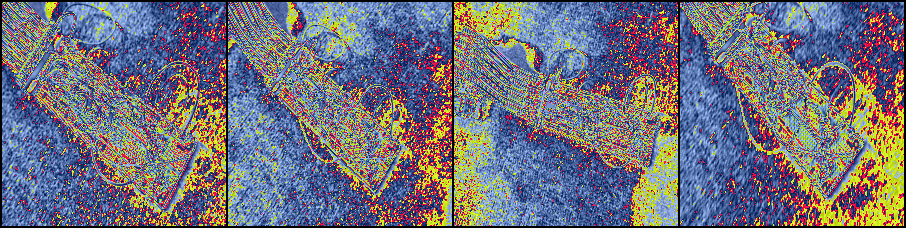

tensor([0, 1, 0, 1])


In [22]:
# データセットの分割
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# 各データセットのtransformを正しく設定
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

# DataLoader の定義
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# データの確認
images, labels = next(iter(train_loader))
c, h, w = images[0].shape
print("ミニバッチサイズ: ", images.size())
print("画像のチャネル数: ", c)
print("画像の高さ: ", h)
print("画像の幅: ", w)

# グリッド上に4枚の画像を表示
img = torchvision.utils.make_grid(images[:4])
img = transforms.functional.to_pil_image(img)
display(img)

# 上の画像に対応するラベルを表示
print(labels[:4])


In [23]:
# ニューラルネットワークに入力する画像のサイズと分類するクラス数を定義
INPUT_CHANNELS = c
OUTPUT_SIZE = 10  # 分類するクラス数

# RestNet152をロード
model = torchvision.models.mobilenet_v2(weights="IMAGENET1K_V1")

# 最終層の出力ユニット数を変更
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, OUTPUT_SIZE)

# モデルをデバイスに転送
model = model.to(device)
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [24]:
# 多クラス分類のための損失関数を定義
criterion = nn.CrossEntropyLoss()

In [25]:
# モデルのパラメータを更新するための最適化手法をAdamで定義
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
# モデルの学習
EPOCHS = 10
train_loss_list = [] # 訓練データの損失リスト
val_loss_list = [] # 検証データの損失リスト

for epoch in range(EPOCHS):
    model.train() # モデルを学習モードに設定
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # データをハードウェアに転送
        optimizer.zero_grad() # 勾配を初期化
        outputs = model(images) # 画像を入力して出力を取得
        loss = criterion(outputs, labels) # 損失を計算
        loss.backward() # 逆伝播
        optimizer.step() # パラメータを更新
        train_loss += loss.item() # 損失を蓄積
    train_loss /= len(train_loader) # バッチサイズで割って平均を取る
    train_loss_list.append(train_loss) # 損失をリストに追加
    
    model.eval() # モデルを評価モードに設定
    val_loss = 0.0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device) # データをハードウェアに転送
        outputs = model(images) # 画像を入力して出力を取得
        loss = criterion(outputs, labels) # 損失を計算
        val_loss += loss.item() # 損失を蓄積
    val_loss /= len(val_loader) # バッチサイズで割って平均を取る
    val_loss_list.append(val_loss) # 損失をリストに追加
    
    print(f'epoch: {epoch+1}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}')

epoch: 1, train_loss: 1.1900, val_loss: 0.6410
epoch: 2, train_loss: 0.0909, val_loss: 0.3412
epoch: 3, train_loss: 0.0643, val_loss: 0.0289
epoch: 4, train_loss: 0.0177, val_loss: 0.0001
epoch: 5, train_loss: 0.0115, val_loss: 0.0001
epoch: 6, train_loss: 0.0038, val_loss: 0.0096
epoch: 7, train_loss: 0.0051, val_loss: 0.0562
epoch: 8, train_loss: 0.0007, val_loss: 0.0085
epoch: 9, train_loss: 0.0006, val_loss: 0.0007
epoch: 10, train_loss: 0.0003, val_loss: 0.0005


Confusion Matrix:
[[11  0]
 [ 0 19]]


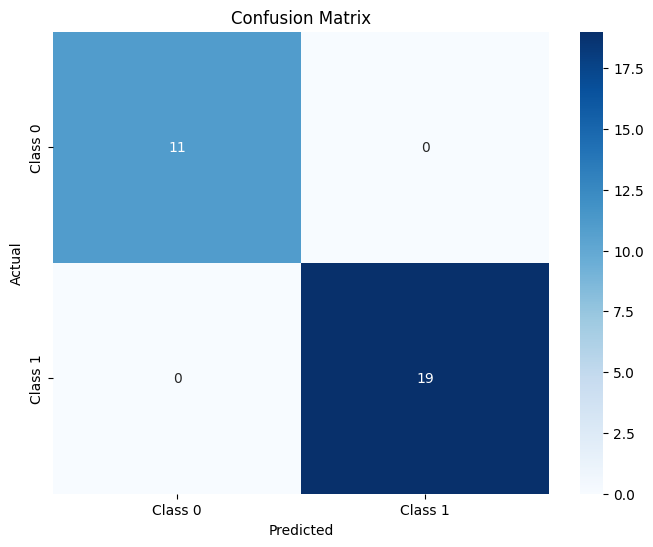

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        11
     Class 1       1.00      1.00      1.00        19

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 検証データでの推論
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:  # val_loader: 検証データのDataLoader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# クラス名とラベルを一致させる
unique_labels = sorted(set(all_labels))  # 出現するクラスラベルを取得
if 'class_names' not in globals() or len(class_names) != len(unique_labels):
    class_names = [f"Class {i}" for i in unique_labels]  # 自動生成（例: "Class 0", "Class 1", ...）

# 混同行列の作成
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# 混同行列の可視化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Precision, Recall, F1スコアのレポート
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:")
print(report)

In [29]:
# モデルの評価
model.eval() # モデルを評価モードに設定
correct = 0 # 正解数
total = 0 # テストデータの総数
with torch.no_grad():
    for images, labels in test_loader: # テストデータを取得
        images, labels = images.to(device), labels.to(device) # データをハードウェアに転送
        outputs = model(images) # 画像をモデルに入力して出力を取得
        _, predicted = torch.max(outputs, 1) # 確率が最大のラベルを取得=モデルによる予測結果を取得
        total += labels.size(0) # labels.size(0)はミニバッチサイズ、毎回加算することでテストデータの総数を計算
        correct += (predicted == labels).sum().item() # 予測と正解ラベルが一致した場合に正解数をカウント
# 正解率を%で表示
print(f'Accuracy: {correct / total * 100:.2f}%')

Accuracy: 100.00%


In [30]:
# 学習済みの重みを保存
# model.state_dict(): モデルの重みを格納したオブジェクト
torch.save(model.state_dict(), "kadai4.pth")